In [1]:
import torch
import matplotlib.pylab as plt
import numpy as np
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.transforms import Compose,RandomHorizontalFlip,Normalize,ToTensor


In [ ]:
# cifar_trainset = datasets.CIFAR10(root='./', train=True, download=True  )
# data = cifar_trainset.data / 255 # data is numpy array

# mean = data.mean(axis = (0,1,2)) 
# std = data.std(axis = (0,1,2))
# print(f"Mean : {mean}   STD: {std}")
# -> Mean : [0.49139968 0.48215841 0.44653091]   STD: [0.24703223 0.24348513 0.26158784]

Files already downloaded and verified
Mean : [0.49139968 0.48215841 0.44653091]   STD: [0.24703223 0.24348513 0.26158784]


In [2]:

mean = np.array([0.49139968, 0.48215841, 0.44653091])
std = np.array([0.24703223, 0.24348513, 0.26158784])
batch_size = 4
transforms = [ToTensor(), Normalize(std, mean)]

train_dataset = datasets.CIFAR10(
    root="./",
    train=True,
    transform=Compose([RandomHorizontalFlip(),*transforms]),
    download=True
    )

test_dataset = datasets.CIFAR10(
    root="./",
    train=False,
    transform=Compose(transforms),
    download=True
    )

train_loader = DataLoader(dataset=train_dataset,batch_size=batch_size,shuffle=True)
test_loader = DataLoader(dataset=test_dataset,batch_size=batch_size,shuffle=False)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./cifar-10-python.tar.gz to ./
Files already downloaded and verified


In [3]:
def im_convert(tensor):  
    image = tensor.cpu().clone().detach().numpy() # This process will happen in normal cpu.
    image = image.transpose(1, 2, 0)
    image = image * std + mean
    image = image.clip(0, 1)
    return image

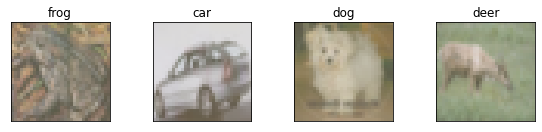

In [4]:
dataiter = iter(train_loader)
images, labels = dataiter.next() 
fig = plt.figure(figsize=(25, 4)) 

# We plot images from our batch
for idx in np.arange(4):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[]) 
  plt.imshow(im_convert(images[idx])) #converting to numpy array as plt needs it.
  ax.set_title(classes[labels[idx].item()])

In [5]:
from torch.nn.functional import cross_entropy, relu
from torch.nn import MaxPool2d, Conv2d, Linear, Module, Dropout
from torch import flatten, no_grad, optim, save, load

In [6]:
class VGGNet(Module):
    def __init__(self, dropout=0.5):
        super(VGGNet, self).__init__()
        self.pool = MaxPool2d(2, 2)
        self.dropout = Dropout(dropout)
        self.conv1 = Conv2d(3, 32, 3, padding=1)
        self.conv2 = Conv2d(32, 32, 3, padding=1)

        self.conv3 = Conv2d(32, 64, 3, padding=1)
        self.conv4 = Conv2d(64, 64, 3, padding=1)

        self.conv5 = Conv2d(64, 128, 3, padding=1)
        self.conv6 = Conv2d(128, 128, 3, padding=1)
        self.conv7 = Conv2d(128, 128, 3, padding=1)

        self.fc1 = Linear(4*4*128, 512)
        self.fc2 = Linear(512, 256)
        self.fc3 = Linear(256, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.pool(relu(x))

        x = self.conv3(x)
        x = self.conv4(x)
        x = self.pool(relu(x))

        x = self.conv5(x)
        x = self.conv6(x)
        x = self.conv7(x)
        x = self.pool(relu(x))

        x = flatten(x, 1)
        x = self.dropout(relu(self.fc1(x)))
        x = self.dropout(relu(self.fc2(x)))
        x = relu(self.fc3(x))
        return x


In [9]:
MODEL_NAME = "myVGG.model"
LR = 1e-3
momentum = 0.9
EPOCH = 40
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [10]:
def train(train_loader, epochs=30, lr=1e-3, momentum=0.9, device='cpu', model_name='myVGG.model', pre_train=False):
    model = VGGNet().to(device)
    if pre_train:
        try:
            model.load_state_dict(load(model_name))
            model.eval()
        except RuntimeError:
            print("model not found!")
            return
        
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    for epoch in range(epochs):
        loss = 0
        if epoch == 6:  # 6 epoch loss increase so reduce lr
            optimizer = optim.SGD(model.parameters(),
                                  lr=lr/10, momentum=momentum)

        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()

            outputs = model(images)
            batchloss = cross_entropy(outputs, labels)
            batchloss.backward()

            optimizer.step()
            loss += batchloss.item()
        print(f"epoch: {epoch} loss: {loss / 2000:.3f}")
    save(model.state_dict(), model_name)

In [11]:

def test(test_loader,device='cpu', model_name='myVGG.model'):
    total = len(test_loader.dataset)
    correct = 0
    model = VGGNet().to(device)
    try:
        model.load_state_dict(load(model_name))
        model.eval()
    except RuntimeError:
        print("model not found!")
        return

    with no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            y = model(images)
            pred_labels = y.max(dim = 1)[1]
            correct += (pred_labels == labels).sum().item()
    print("correct: ", correct)
    print("total: ", total)
    print(f"accuaracy: {correct/float(total)*100}%",)

In [12]:

def test_every_classed(test_loader, classes, device='cpu', model_name='myVGG.model'):
    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}
    model = VGGNet().to(device)
    model.load_state_dict(load(model_name))
    model.eval()
    with no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            y = model(images)
            pred_labels = y.max(dim = 1)[1]
            for label, prediction in zip(labels, pred_labels):
                if label == prediction:
                    correct_pred[classes[label]] += 1
                total_pred[classes[label]] += 1
    for classname, correct_count in correct_pred.items():
        accuracy = 100 * float(correct_count) / total_pred[classname]
        print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

In [13]:
train(train_loader,model_name= MODEL_NAME,device=DEVICE)


epoch: 0 loss: 14.146
epoch: 1 loss: 10.414
epoch: 2 loss: 7.546
epoch: 3 loss: 6.510
epoch: 4 loss: 6.115
epoch: 5 loss: 5.904
epoch: 6 loss: 4.210
epoch: 7 loss: 3.688
epoch: 8 loss: 3.466
epoch: 9 loss: 3.293
epoch: 10 loss: 3.163
epoch: 11 loss: 3.036
epoch: 12 loss: 2.923
epoch: 13 loss: 2.846
epoch: 14 loss: 2.717
epoch: 15 loss: 2.652
epoch: 16 loss: 2.544
epoch: 17 loss: 2.462
epoch: 18 loss: 2.389
epoch: 19 loss: 2.331
epoch: 20 loss: 2.248
epoch: 21 loss: 2.175
epoch: 22 loss: 2.126
epoch: 23 loss: 2.038
epoch: 24 loss: 1.957
epoch: 25 loss: 1.891
epoch: 26 loss: 1.841
epoch: 27 loss: 1.782
epoch: 28 loss: 1.746
epoch: 29 loss: 1.665


In [14]:
test(test_loader,model_name= MODEL_NAME,device=DEVICE)


correct:  8388
total:  10000
accuaracy: 83.88%


In [15]:
test_every_classed(test_loader,classes,device=DEVICE,model_name= MODEL_NAME)

Accuracy for class: plane is 85.8 %
Accuracy for class: car   is 92.4 %
Accuracy for class: bird  is 71.0 %
Accuracy for class: cat   is 66.2 %
Accuracy for class: deer  is 86.8 %
Accuracy for class: dog   is 78.4 %
Accuracy for class: frog  is 90.3 %
Accuracy for class: horse is 87.6 %
Accuracy for class: ship  is 88.4 %
Accuracy for class: truck is 91.9 %
